<a target="_blank" href="https://colab.research.google.com/github/umanitoba-meagher-projects/public-experiments/blob/main/jupyter-notebooks/Object%20Classification%20and%20Localization/dataset-sizes-confusion-matrix.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:

"""
Author: Zhenggang Li & A.V. Ronquillo
Date: May 21, 2024

Updated: August 06, 2025:
- Google Drive data access replaced with Borealis data

## Note: Note: The author generated this text in part with GPT-4,
OpenAI’s large-scale language-generation model. Upon generating
draft code, the author reviewed, edited, and revised the code
to their own liking and takes ultimate responsibility for
the content of this code.

"""

# Introduction

This Jupyter Notebook evaluates image classification model performance, using confusion matrices to visualize prediction accuracy and identify common misclassification patterns. It uses Python libraries like `NumPy`, `Matplotlib`, and `Scikit-learn` to process datasets, apply trained models, and create interpretable performance visualizations. The notebook serves as both a debugging tool for improving model accuracy and a practical guide for applying machine learning evaluation techniques to image classification tasks.



## Critical Uses & Adaptability

### What the Notebook Can Be Used For:
- **Dataset Exploration:**
This notebook is particularly useful for analyzing datasets related to animal behavior and interactions. It can be used to group data into meaningful sequences, identify patterns, and visualize relationships. For example, the `group_sequences()` function and the logic in `# Process each locationID` enable exploration of temporal and spatial data.

- **Educational Tool for Data Analysis:**
The notebook demonstrates practical applications of Python for data analysis and visualization. It integrates libraries like Pandas for data manipulation, Matplotlib for plotting, and NetworkX for graph-based visualizations. These examples make it a valuable resource for teaching concepts such as feature extraction, data grouping, and network analysis.

- **Feature Engineering:**
The notebook extracts key features from raw data, such as interaction counts, time intervals, and species relationships. These features are used to construct a network graph that highlights behavioral patterns.

- **Visualization of Relationships:**
By creating network graphs, the notebook provides a visual representation of animal interactions. This is particularly useful for understanding complex relationships, such as species co-occurrence or movement patterns, as seen in the `draw_curved_edges()` function.

### How the Notebook Can Be Adapted:

- **Customizing Variables:**
Key variables like `time_diff` and `locationID` can be adjusted to suit different datasets or research objectives. For example, the time threshold for defining interactions can be modified in the `# Process each locationID` block to analyze relationships over different time scales.

- **Using Alternative Datasets:**
The notebook is designed to be flexible with datasets. Users can replace the input dataset by modifying the file paths in the `# File paths` section. While the dataset structure should align with the expected format, minor adjustments to the data processing steps can accommodate variations.



# Module: Import Python Packages and Mount Google Drive
In this module, we import essential packages for image processing and display them within Google CoLab Notebook. `fastai.vision.all` is a comprehensive library that includes all necessary methods for computer vision tasks, facilitating model building, training, and evaluation with just a few lines of code.

Additionally, mounting `google.colab import drive` gives the CoLab environment direct access to the dataset and files that will be used for analysis. Similarly, by importing the `Paths` class from `pathlib`, easier file manipulation can be utilized. `pathlib` is a module in the Python Standard Library that aids in handling filesystem paths with semantics that are appropriate for different operating systems.

In [ ]:
import os
from google.colab import drive
from fastai.vision.all import *
from pathlib import Path
import matplotlib.pyplot as plt # Import matplotlib for plt.show()

##### Google Drive File Path
Implementing a function to mount Google Drive is needed in CoLab to enable files access. It uses `drive.mount('/content/drive', force_remount=True)` to force-mount the drive even if already mounted to ensure the session's directory structure is updated, followed by a print statement confirming the mount.

In [ ]:
def mount_google_drive():
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive is mounted. Proceed with file operations.")

if __name__ == "__main__":
    mount_google_drive()
    # Define base_path here after mounting the drive
    base_path = '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets'
    print(f"Base path set to: {base_path}") # Optional: confirm path is set

Mounted at /content/drive
Google Drive is mounted. Proceed with file operations.
Base path set to: /content/drive/My Drive/shared-data/Notebook datafiles/av datasets


# Module: Iterate Images for Error Handling

This section explains a function that safely gets image files from a given path. It allows the entire python script to be more robust because it prepares the image processing to be able to deal with unidentified or corrupted images.

The code takes an arguement of the `path` to the directory containing the images and initializes an empty list `"[]"` called `image_files`. This list will store the paths to the valid image files. Using the `get_image_files(path)` function in a `for` loop statement, this line of code iterates through the image files in the specified path.

For each image file, it attempts to open the image using the `PILImage.create()` function. If the image can be opened successfully, it means that the image is not corrupted and it is added to the `image_files` list. It will simply skip the image if an error occurs while opening the file and an indication of an error is printed. The function then runs through a `return` of the list of valid image files, ensuring that the image files used for training the model is not corrupted, which can lead to errors during training and can affect the performance of the model.

In [ ]:
def safe_get_image_files(path):
    image_files = []
    for img_path in get_image_files(path):
        try:
            # Attempt to open the image to verify it is not corrupted
            with PILImage.create(img_path) as img:
                image_files.append(img_path)
        except Exception as e:
            print(f"Skipping file {img_path} due to error: {e}")
    return image_files

# Module: Gather Image Files & Create the Confusion Matrix

This section of the notebook explains the process of gathering the input files, initializing the ResNet34 model with fastai, and processing the confusion matrix itself.

Firstly, this module shows the function that processes image datasets for different dataset sizes. It states the three arguments, the `base_path` to the directory containing the image datasets , a list of `species` names, and a list of `dataset_sizes` that is iterated through. For each dataset size, it then initializes an empty list `"[]"` called `files`.

By using another `for` loop statement, the `species` list is also iterated through. For each species, it constructs the `path` to the directory containing the images for that species and dataset size `{animal}_{size}` from each of their respective folders in the Google Drive. The code then calls the `safe_get_image_files()` function to get a list of image files from the directory and adds the list of image files to the `files` list. If this files list is empty, it means that no valid image files were found for the current dataset size, which would print a message and skips processing the dataset size.

## Initialize Data Loaders
The function that initializes the data loaders for a given dataset is used to create a PyTorch DataLoader for images. If the files list is not empty, it initializes the data loaders using the `ImageDataLoaders.from_path_func()` function. The data loaders are used to load and pre-process the images, it then displays a batch of images from the data loaders through the use of the `dls.show_batch()` function. The `fnames` argument is the list of strings where each string is the `files` name of an image. The `label_func` argument then extracts the label for each image through the use of `lambda x`.

Transformations are applied to each batch of images to be resized to 224x224 through the `aug_transforms()` argument. The batch is displayed after the validation is set.

In [ ]:
def process_single_dataset(base_path, species, size):
    print(f"\n--- Processing {size} Dataset ---")
    files = []

    # Gather files for all species for the given size
    for animal in species:
        # Use the base_path passed as an argument
        path = Path(base_path) / f'{animal}_{size}'
        files += safe_get_image_files(path)

    if not files:
        print(f"No images found for dataset size {size}. Skipping...")
        return

    # Initialize Data Loaders
    dls = ImageDataLoaders.from_path_func(
        path=Path(base_path), # Use the base_path passed as an argument
        fnames=files,
        label_func=lambda x: x.parent.name.split('_')[0],
        item_tfms=Resize(460),
        batch_tfms=aug_transforms(size=224),
        bs=32,
        num_workers=0,
        valid_pct=0.2
    )

    dls.show_batch()

    # Initialize CNN Learner and Fine-Tune the Model
    learn = cnn_learner(dls, resnet34, metrics=accuracy)
    learn.fine_tune(4)

    # Display Model Results
    learn.show_results()

    # Interpret the Results and Plot a Confusion Matrix
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(title=f"{size} Dataset")
    plt.show()
    print(f'Processed dataset size {size}')
    print('-' * 60)

## Initialize CNN Learner & Fine-Tune the Model
The learner is intialized using a pre-trained convolutional neural network (CNN) architecture `resnet34`, in doing so, it sets up the model to measure `accuracy` as its performance metric. The model is then fine-tuned for `(4)` epochs, it adapts the pre-trained network's weights based on the specific data provided through `dls`, enhancing its ability to perform well on this particular dataset of animal images.

Running the `learn.show_results()` generates a visualization that will aid in qualitatively assesing how the model is performing. For this image classification tasks, a grid of images from the validation set is displayed.
Each image in the displayed grid is annotated with the prediction made by the model and the true label. This dual annotation helps in quickly spotting where the model is performing well and where it is making errors.
This method is useful for getting a quick visual assessment of the effectiveness of the model.

## Plot a Confusion Matrix & Label the Datasets

The results of the model's performance is interpreted and visualized through a confusion matrix.

The `interp` variable is used to store the `ClassificationInterpretation` object. This object is a class from the "fastai" library designed to help interpret the outcomes of classification models. An interpretation of the results is then generated based on the trained model data, plotting a confusion matrix through `plt.show`. The number of correct and incorrect predictions made by the model compared with the actual classifications is displayed in the visual.

Additionally, the confusion matrix plot is represented with a labelled annotation of the dataset. `{size}` is replaced by the size of the dataset being used, and it is integrated dynamically into the title string. For example, the confusion matrix across the animal species in the dataset of 100 is labelled as "100 Dataset" at the top of the confusion matrix.

To further the clarification of the script's output, `60` dashes `'-'`, are printed to graphically separate the 100, 500, and 1000 Datasets.

## Process Datasets

The necessary files from Google Drive are then made accessible and it eventually triggers the processing for each dataset size. It sets up the parameters for which data to process, including which `dataset_sizes` folder the images are stored in and what specific subdivisions or `species` of the data is to be used in the processing. This first run of the script is the 100 Dataset, the same steps are repated for each dataset in the notebook.

# Module: 100 Dataset


--- Processing 100 Dataset ---


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 117MB/s]


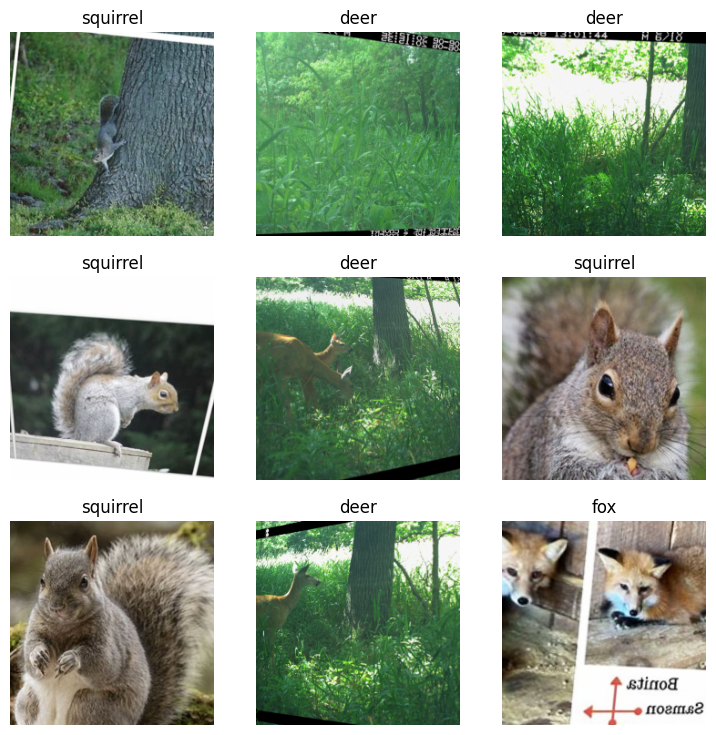

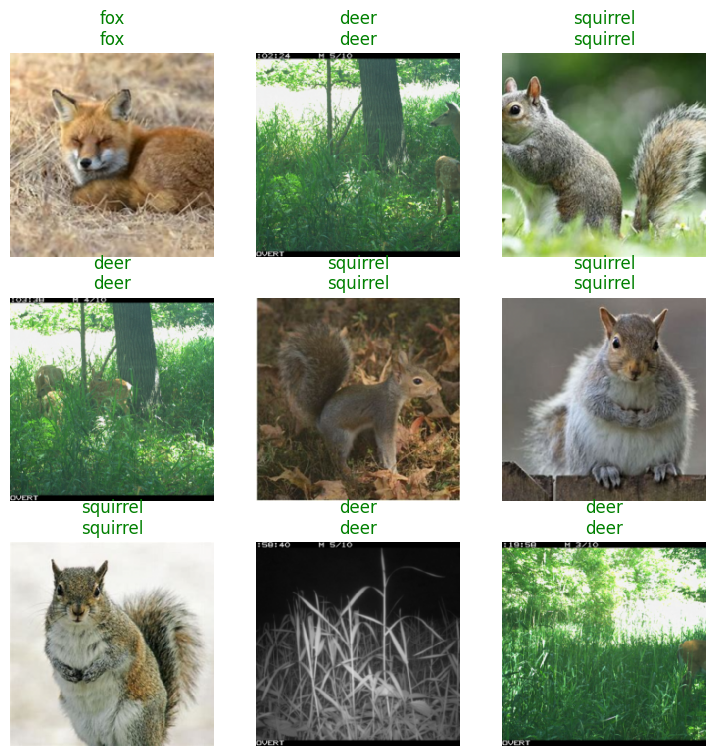

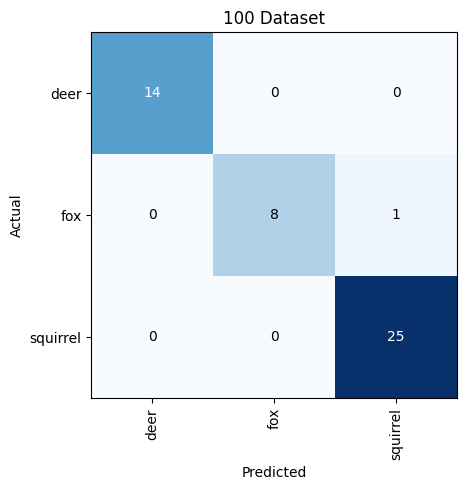

Processed dataset size 100
------------------------------------------------------------


In [ ]:
if __name__ == "__main__":
    # base_path is now defined in an earlier cell
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 100
    # Pass the globally defined base_path to the function
    process_single_dataset(base_path, species, dataset_size)


# Module: 500 Dataset


--- Processing 500 Dataset ---


/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


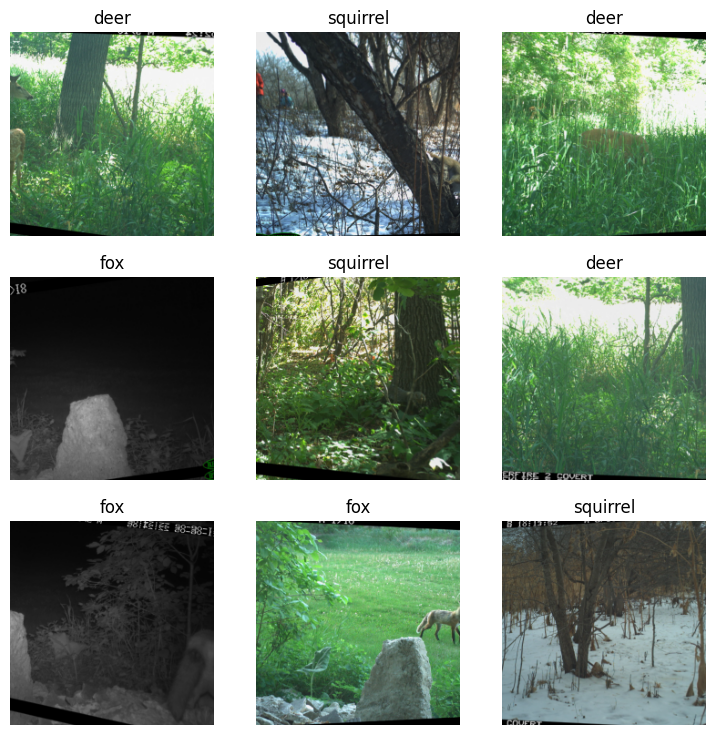

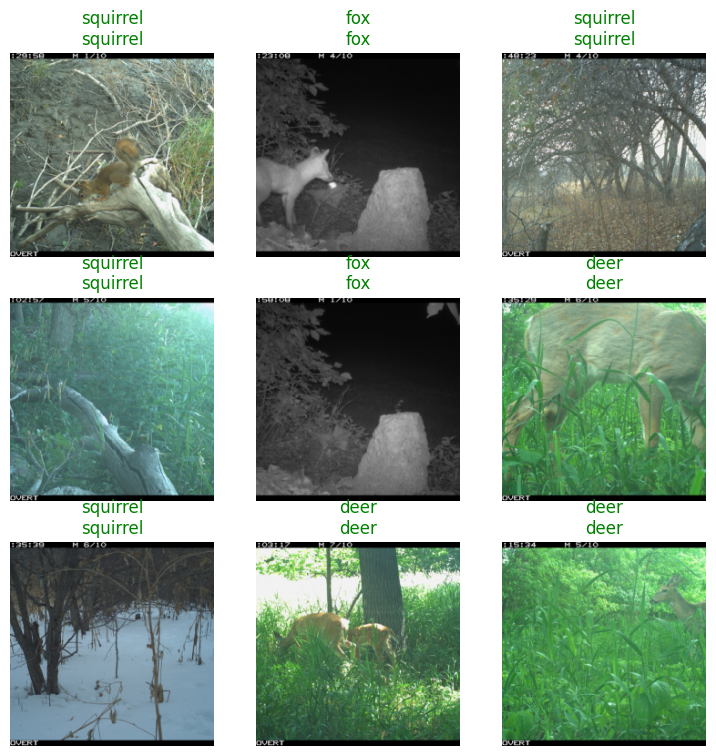

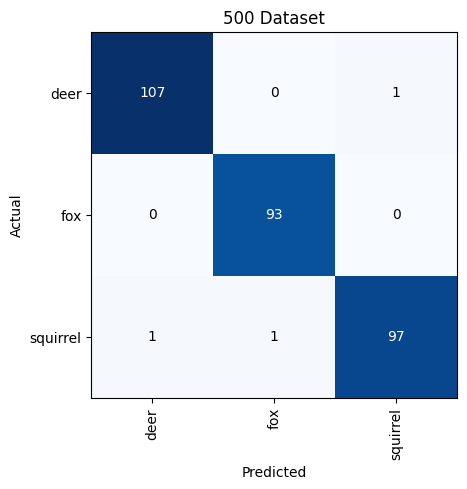

Processed dataset size 500
------------------------------------------------------------


In [ ]:
if __name__ == "__main__":
    # base_path is now defined in an earlier cell
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 500
    # Pass the globally defined base_path to the function
    process_single_dataset(base_path, species, dataset_size)

# Module: 1000 Dataset


--- Processing 1000 Dataset ---
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_132.JPG due to error: cannot identify image file '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_132.JPG'
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_121.JPG due to error: cannot identify image file '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_121.JPG'
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_13.JPG due to error: cannot identify image file '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_13.JPG'
Skipping file /content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_11.JPG due to error: cannot identify image file '/content/drive/My Drive/shared-data/Notebook datafiles/av datasets/fox_1000/fox_11.JPG'
Skipping file /content/drive/My Drive/s

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


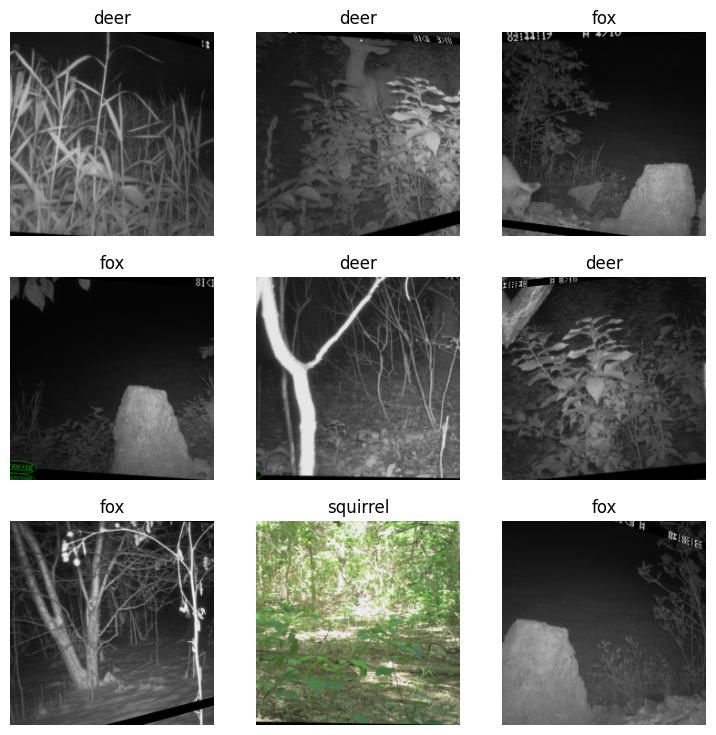

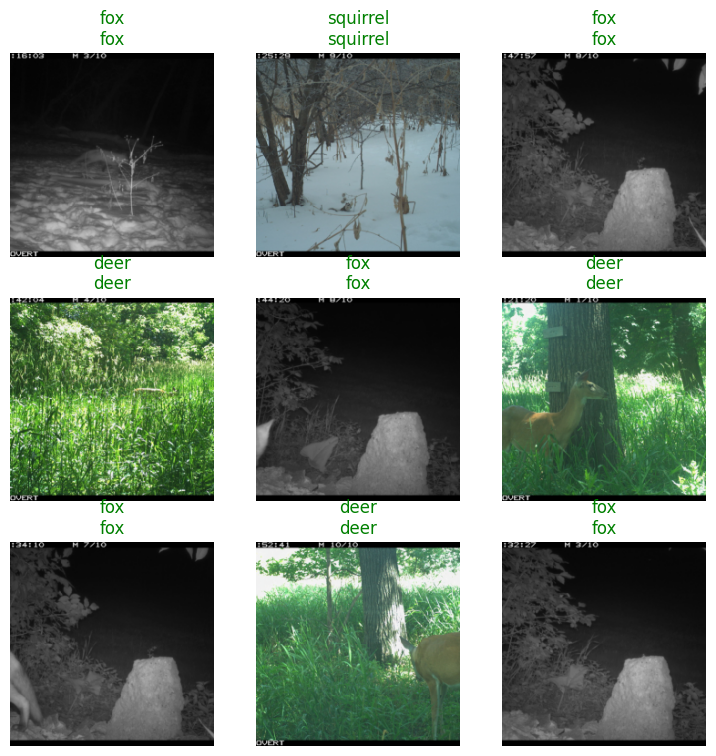

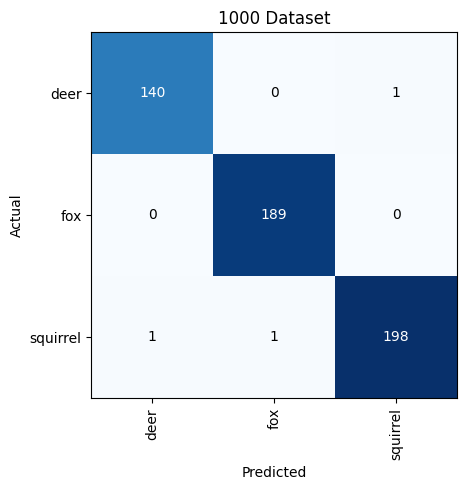

Processed dataset size 1000
------------------------------------------------------------


In [ ]:
if __name__ == "__main__":
    # base_path is now defined in an earlier cell
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 1000
    # Pass the globally defined base_path to the function
    process_single_dataset(base_path, species, dataset_size)

# Module: 5000 Dataset
Please note that because this script deals with such a large dataset, the free version of the CoLab environment is inadequate for the task. Therefore, the entire script was processed through the WSL environment on Linux and it was also tested in the cloud server of the Digital Research Alliance of Canada. Screenshots of the results are shown below.

In [ ]:
if __name__ == "__main__":
    # base_path is now defined in an earlier cell
    species = ['fox', 'squirrel', 'deer']
    dataset_size = 5000
    # Pass the globally defined base_path to the function
    process_single_dataset(base_path, species, dataset_size)

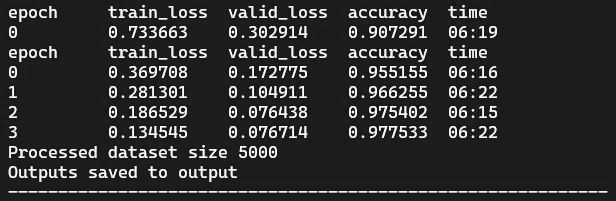

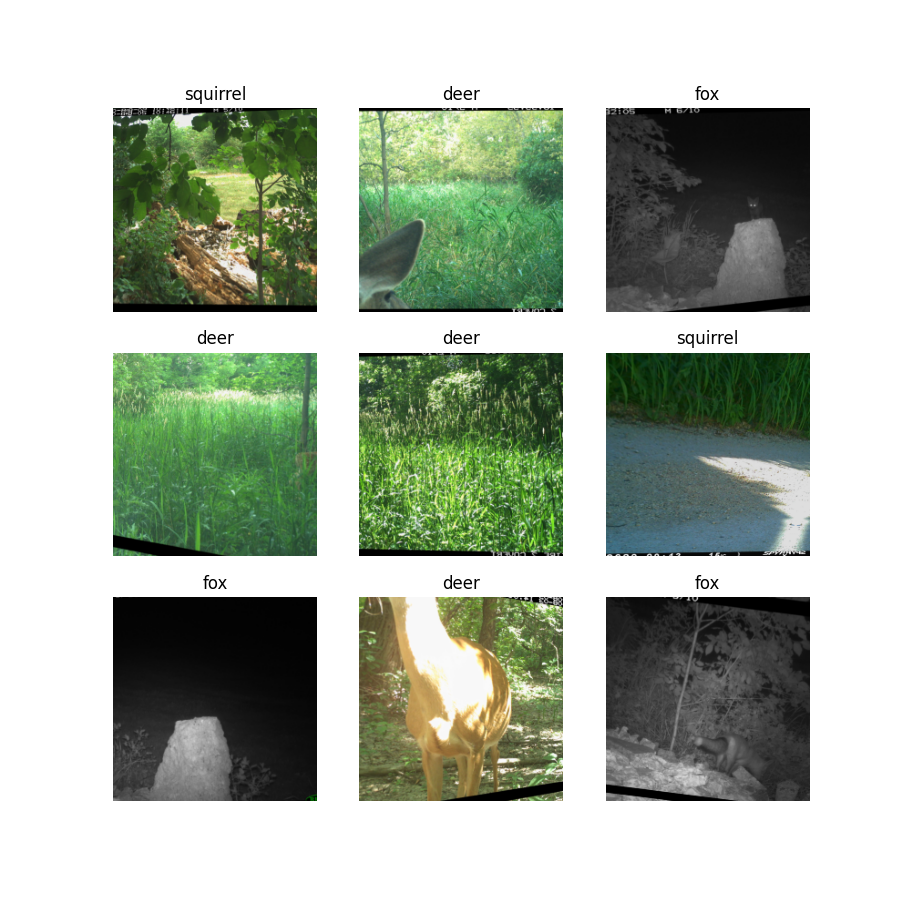

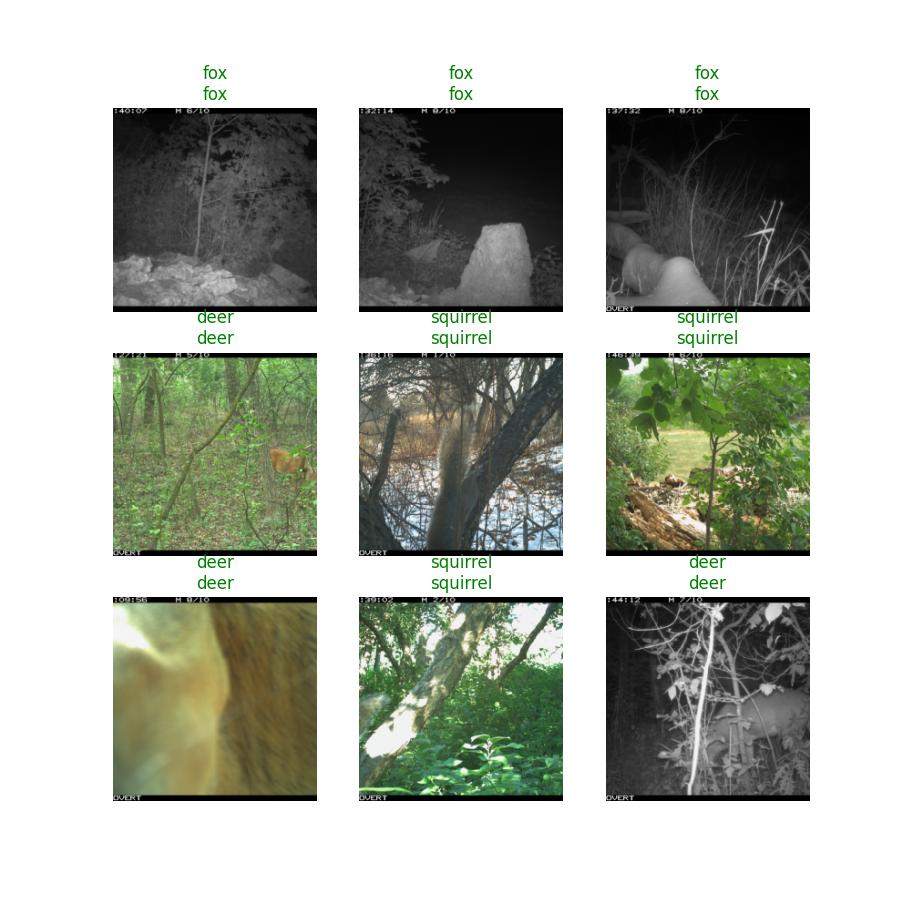

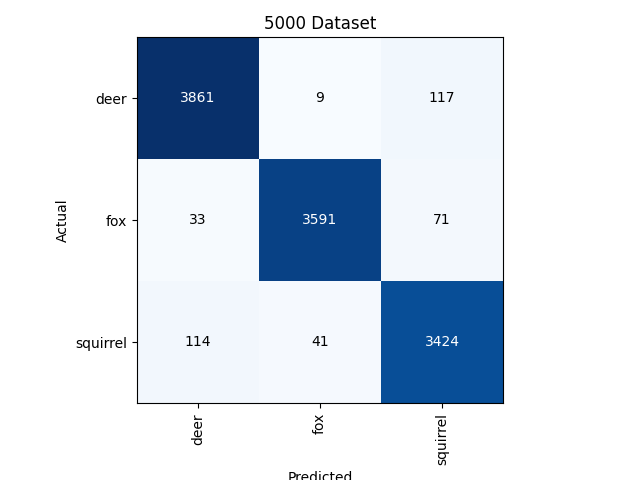